# 20220327-zoo-stats
- Cumulative statistics (weighted over simpoints)
    - Accuracy
    - Coverage
    - IPC improvement (over no prefetcher)
    - MPKI reduction (over no prefetcher)
    - DRAM bandwidth reduction (over no prefetcher)
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

from utils import utils, stats

from importlib import reload
reload(utils)

<module 'utils.utils' from '/u/cmolder/GitHub/prefetching-zoo/utils/utils.py'>

In [2]:
data_path = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo.csv' # Make sure it is filtered on best-performing degree first (if multiple degrees of the same prefetcher combo are present).
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

# Add SPEC / GAP results.
df = utils.read_data_file(data_path)
weights = utils.read_weights_file(weight_path)

In [3]:
# Add CloudSuite results
data_path_cs = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_cloudsuite.csv'
df_cs = utils.read_data_file(data_path_cs)
df = df.append(df_cs)

In [4]:
# Add PC trace (max accuracy, max num useful) results
data_path_pctrace_accuracy = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_pctrace_accuracy.csv'
data_path_pctrace_num_useful = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_pctrace_num_useful.csv'
data_path_pctrace_marg_useful = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_pctrace_marginal_useful.csv'

df_pta = utils.read_data_file(data_path_pctrace_accuracy)
df_ptnu = utils.read_data_file(data_path_pctrace_num_useful)
df_ptmu = utils.read_data_file(data_path_pctrace_marg_useful)
df_pta.prefetcher = 'pc_combined_acc'
df_ptnu.prefetcher = 'pc_combined_num_useful'
df_ptmu.prefetcher = 'pc_combined_marg_useful'

df = df.append(df_pta)
df = df.append(df_ptnu)
df = df.append(df_ptmu)

In [5]:
pd.set_option('display.max_rows', 100)
display(df.prefetcher.unique())
df[df.full_trace == 'astar_313B']

array(['bingo', 'bo', 'pythia', 'sisb', 'sms', 'bingo_bo', 'bingo_sisb',
       'bingo_sms', 'spp', 'bingo_spp', 'bingo_pythia', 'bo_pythia',
       'bo_sisb', 'bo_sms', 'bo_spp', 'pythia_sisb', 'sisb_sms',
       'pythia_sms', 'pythia_spp', 'sisb_spp', 'sms_spp',
       'pc_combined_acc', 'pc_combined_num_useful',
       'pc_combined_marg_useful'], dtype=object)

,full_trace,trace,simpoint,prefetcher,degree,accuracy,coverage,mpki,mpki_reduction,dram_bw_epochs,dram_bw_reduction,ipc,ipc_improvement,baseline_prefetcher,path,baseline_path
0,astar_313B,astar,313B,bingo,"(1,)",7.510935,10.042053,33.392299,43.553889,1801113,6.848796,0.11012,7.465600,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
1,astar_313B,astar,313B,bo,"(1,)",35.830000,-3.254804,38.328079,35.210481,1940306,-0.350084,0.10211,-0.351322,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
2,astar_313B,astar,313B,pythia,"(1,)",45.038247,8.465109,33.977659,42.564401,1756038,9.180016,0.11299,10.266419,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
3,astar_313B,astar,313B,sisb,"(8,)",79.860558,35.568630,23.916860,59.571107,1357706,29.781225,0.14682,43.280960,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
4,astar_313B,astar,313B,sms,"(6,)",35.822220,3.964935,35.648119,39.740667,1826206,5.551019,0.10858,5.962721,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
5,astar_313B,astar,313B,bingo_bo,"(1, 3)",7.448110,10.211019,33.329579,43.659911,1806630,6.563464,0.10978,7.133795,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
6,astar_313B,astar,313B,bingo_sisb,"(1, 8)",11.964350,35.780269,23.838300,59.703904,1555208,19.566680,0.12784,24.758466,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
7,astar_313B,astar,313B,bingo_sms,"(1, 6)",7.667927,12.305529,32.552099,44.974157,1797432,7.039172,0.11035,7.690056,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
8,astar_313B,astar,313B,spp,"(1,)",58.597920,-3.559438,38.441159,35.019331,1938848,-0.274678,0.10219,-0.273251,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...
9,astar_313B,astar,313B,bingo_spp,"(1, 1)",7.677200,10.562852,33.198979,43.880676,1795310,7.148919,0.11048,7.816922,no,/scratch/cluster/cmolder/prefetcher_degree_swe...,/scratch/cluster/cmolder/prefetcher_degree_swe...


---
## Helper functions

In [6]:
all_opportunity_prefetchers = ['phase_combined', 'pc_combined_acc', 'pc_combined_num_useful', 'pc_combined_marg_useful']

def _get_label(prefetcher, prefetcher_list=None):
    if prefetcher in all_opportunity_prefetchers:
        return prefetcher
    else: return f'({prefetcher_list.index(prefetcher)+1}) {prefetcher}' if prefetcher_list is not None else prefetcher
    
def _get_color(prefetcher):
    colors = {
        'phase_combined': 'blue',
        'pc_combined_acc': 'limegreen',
        'pc_combined_num_useful': 'forestgreen',
        'pc_combined_marg_useful': 'darkgreen',
    }
    if prefetcher in colors.keys():
        return colors[prefetcher]
    else: return None
    
def _get_hatch(prefetcher):
    return None
    # if prefetcher in ['phase_combined', 'pc_combined_acc', 'pc_combined_nuseful']:
    #     return '/'
    # else: return None

def plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                               prefetchers=None,
                               opportunity_prefetchers=all_opportunity_prefetchers,
                               benchmarks=None,
                               dpi=192,
                               ymin=None, ymax=None):
    
    # Filter benchmarks (if wanted)
    if benchmarks is not None:
        df = df[df.trace.isin(benchmarks)]
        
    # Filter or weight simpoints  
    # Add phase_combined
    if method == 'weighted':
        df = stats.get_weighted_statistics(df, weights, add_phase_combined=True) # Weighted simpoints
    else:
        df = df[df.full_trace.isin(stats.get_longest_simpoints(weights))] # Longest simpoint

    # Filter prefetchers (if wanted) by weighted simpoints
    if prefetchers is not None:
        df = df[df.prefetcher.isin(prefetchers + opportunity_prefetchers)]
    
    # Plot
    df = df.sort_values('trace',key=lambda col: col.str.lower())
    traces = df['trace'].unique()
    num_prefetchers = len(df.groupby('prefetcher'))
    num_traces = len(df.groupby('trace'))
    mean_metric = 'amean' if metric in utils.amean_metrics else 'gmean'
    sep = 3
    
    fig, ax = plt.subplots(figsize=(14, 6), dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    if prefetchers is not None:
        pf_list = prefetchers + opportunity_prefetchers
    else:
        pf_list = df.prefetcher.unique()

    for i, pf in enumerate(pf_list):
        df_pf = df[df.prefetcher == pf]
        y = df_pf[metric].to_numpy()
        y = np.append(y, utils.mean(y, metric))
        X = np.arange(0, len(y)) * (num_prefetchers + sep) + i
        label = _get_label(pf, prefetchers)
        color = _get_color(pf)
        hatch = _get_hatch(pf)
        ax.bar(X, y, label=label, color=color, hatch=hatch)
        
    ax.set_yticks(np.arange(ymin, ymax, 10))
    ax.set_xticks(np.arange(0, len(traces) + 1) * (num_prefetchers + sep) + (num_prefetchers)/2)
    ax.set_xticklabels(traces.tolist() + [mean_metric], rotation=45)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    
    fig.suptitle(f'{metric} ({method} simpoint)')
    ax.set_xlabel('Trace')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax) 
    fig.tight_layout()

---
## SPEC '06 cumulative statistics

### Top 5 by IPC improvement

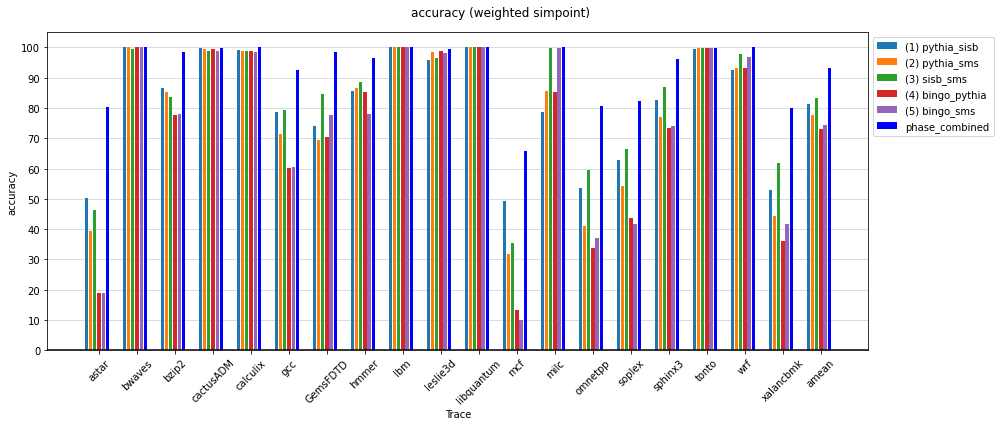

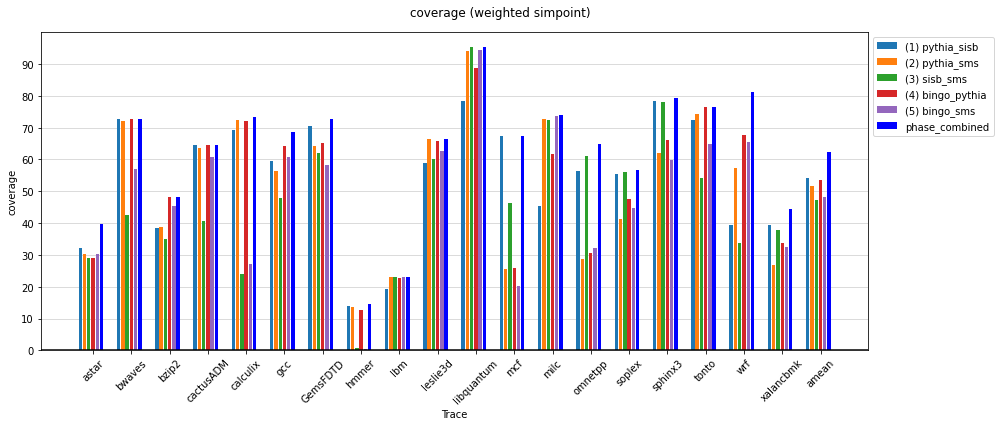

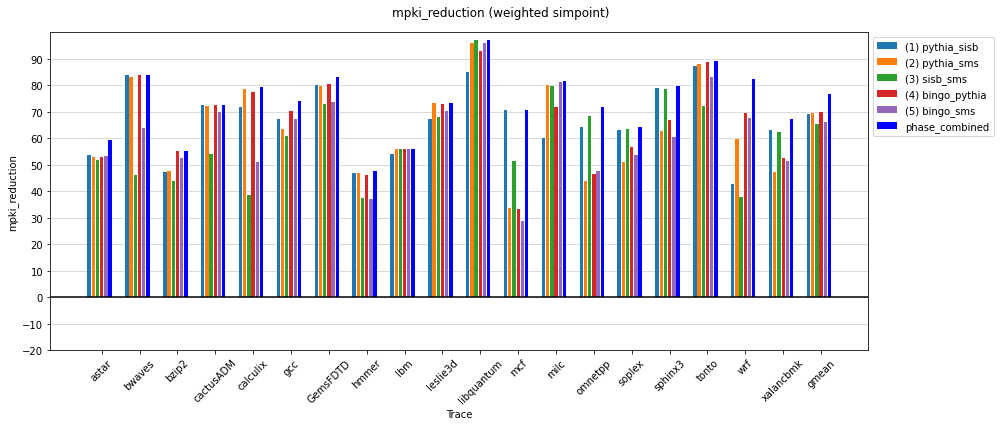

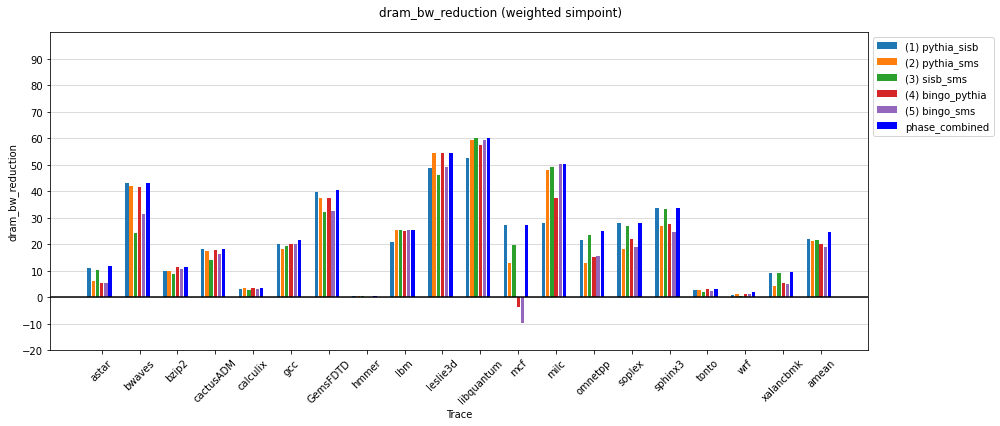

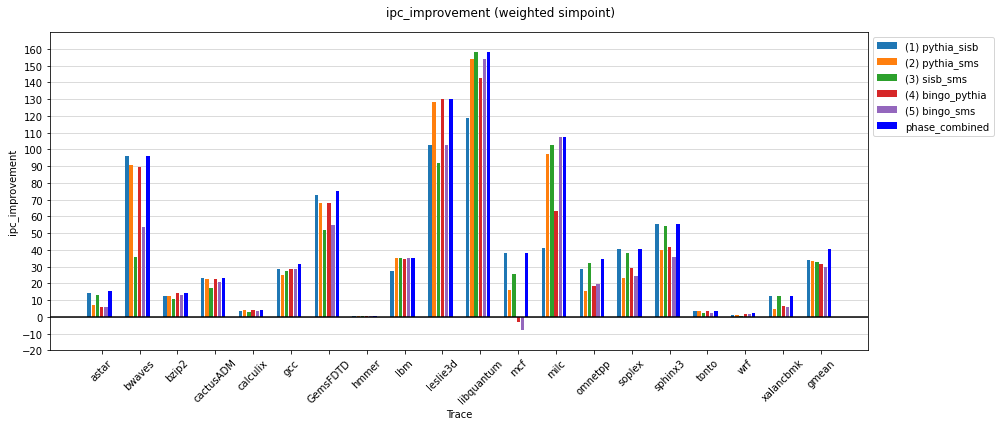

In [7]:
spec_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.spec)], 'ipc_improvement', 5)
opp_pref = ['phase_combined']
dpi = None

# Accuracy
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           prefetchers=spec_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.spec,
                           ymin=0, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/accuracy_5_spec.pdf')

# Coverage
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           prefetchers=spec_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.spec,
                           ymin=0, ymax=100, dpi=dpi)
plt.savefig('plots/zoo-stats/coverage_5_spec.pdf')

# MPKI reduction
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=spec_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.spec,
                           ymin=-20, ymax=100, dpi=dpi)
plt.savefig('plots/zoo-stats/mpki_reduction_5_spec.pdf')

# DRAM bandwidth reduction
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=spec_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.spec,
                           ymin=-20, ymax=100, dpi=dpi)
plt.savefig('plots/zoo-stats/dram_bw_reduction_5_spec.pdf')

# IPC improvement
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=spec_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.spec,
                           ymin=-20, ymax=170, dpi=dpi)
plt.savefig('plots/zoo-stats/ipc_improvement_5_spec.pdf')

### Opportunity prefetchers

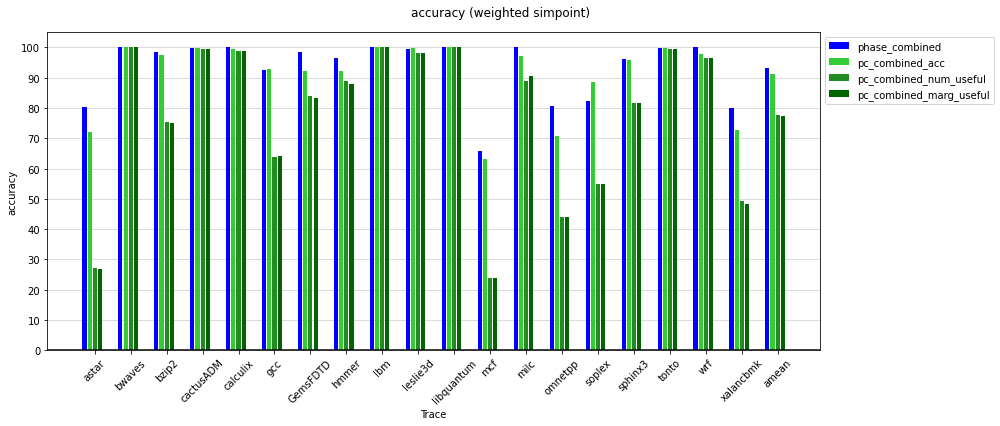

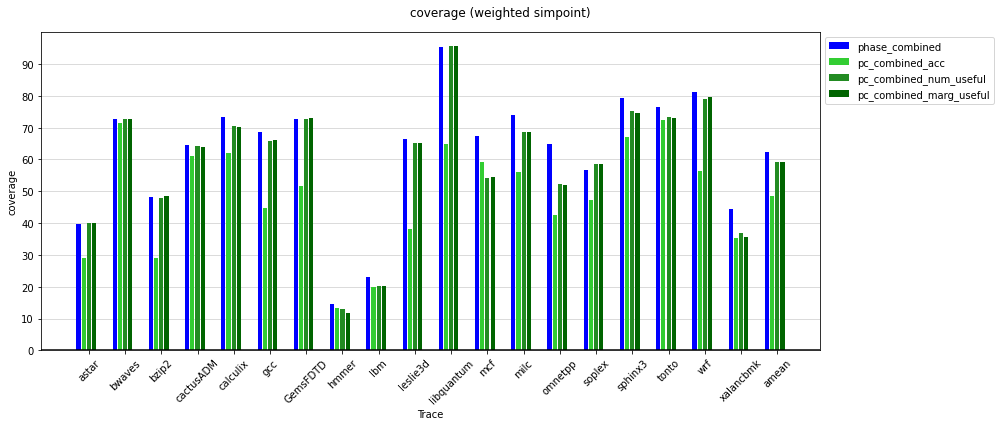

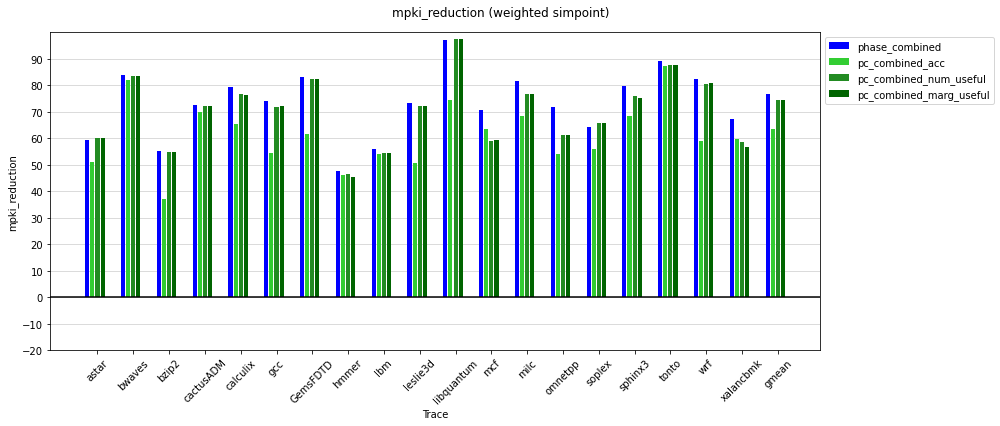

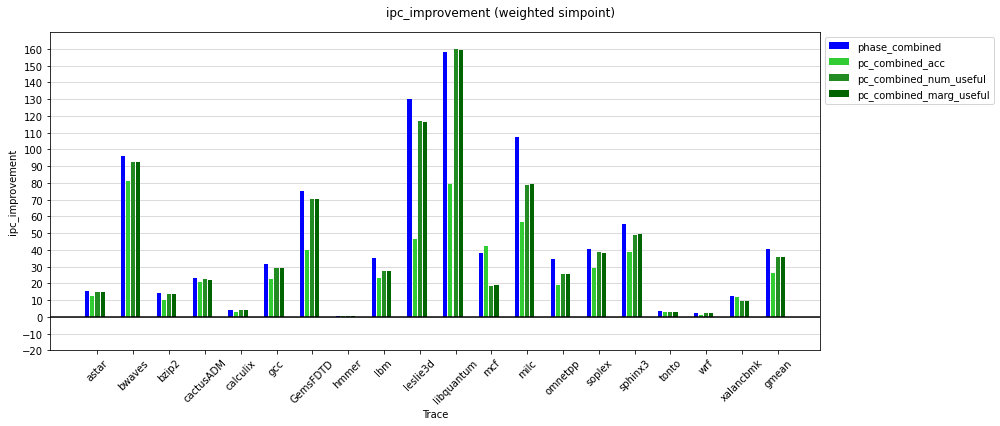

In [8]:
dpi = None

# Accuracy
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           prefetchers=[],
                           benchmarks=utils.spec,
                           ymin=0, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/accuracy_opportunity_spec.pdf')

# Coverage
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           prefetchers=[],
                           benchmarks=utils.spec,
                           ymin=0, ymax=100, dpi=dpi)
plt.savefig('plots/zoo-stats/coverage_opportunity_spec.pdf')

# MPKI reduction
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=[],
                           benchmarks=utils.spec,
                           ymin=-20, ymax=100, dpi=dpi)
plt.savefig('plots/zoo-stats/mpki_reduction_opportunity_spec.pdf')

# IPC improvement
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=[],
                           benchmarks=utils.spec,
                           ymin=-20, ymax=170, dpi=dpi)
plt.savefig('plots/zoo-stats/ipc_improvement_opportunity_spec.pdf')

---
## GAP cumulative statistics

### Top 5 by IPC improvement
- Note: Weighted vs. longest simpoint doesn't matter here, since all gap traces are single-simpoint.

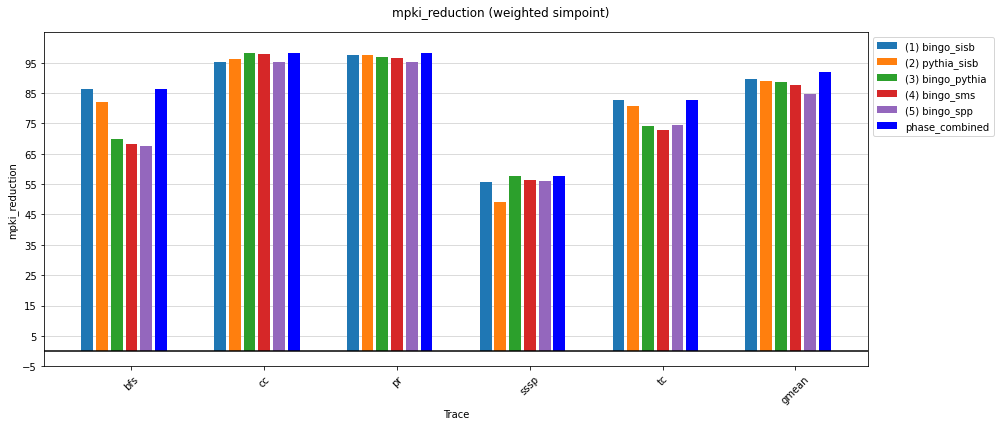

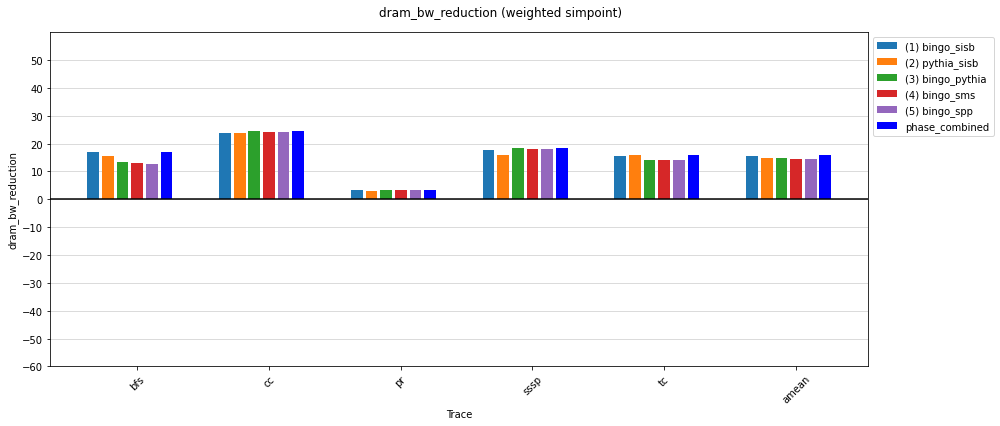

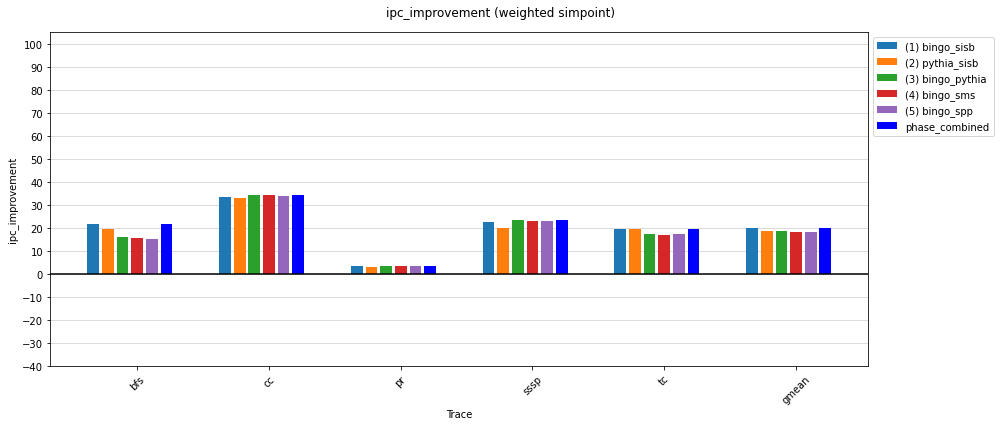

In [9]:
gap_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.gap)], 'ipc_improvement', 5)
opp_pref = ['phase_combined']
dpi = None

# MPKI reduction
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=gap_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.gap,
                           ymin=-5, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/mpki_reduction_5_gap.pdf')

# DRAM bw reduction
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=gap_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.gap,
                           ymin=-60, ymax=60, dpi=dpi)
plt.savefig('plots/zoo-stats/dram_bw_reduction_5_gap.pdf')

# IPC improvement
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=gap_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.gap,
                           ymin=-40, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/ipc_improvement_5_gap.pdf')

### Single prefetchers

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

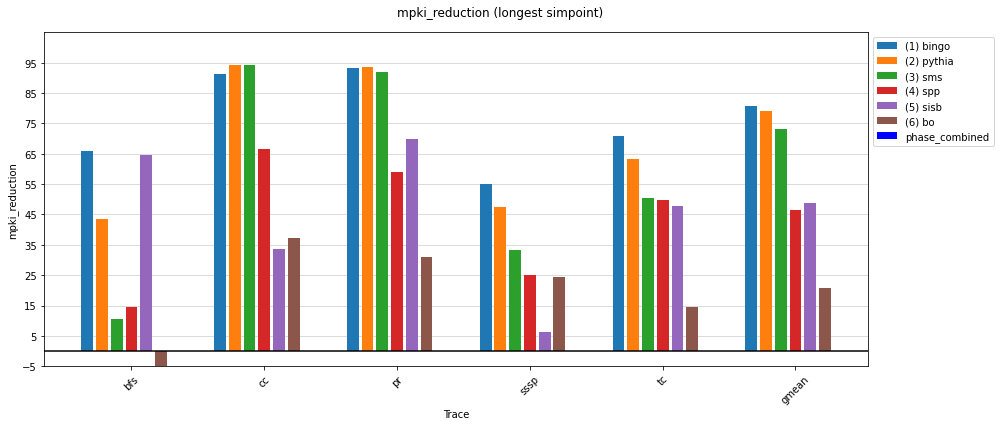

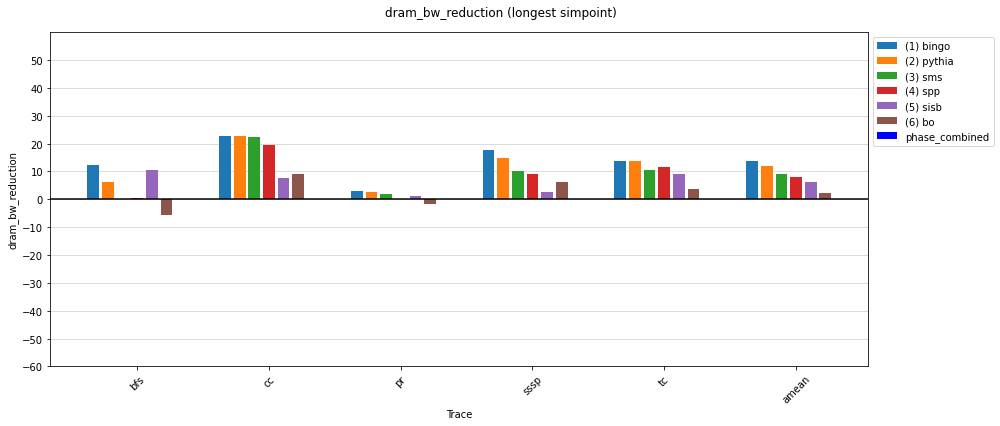

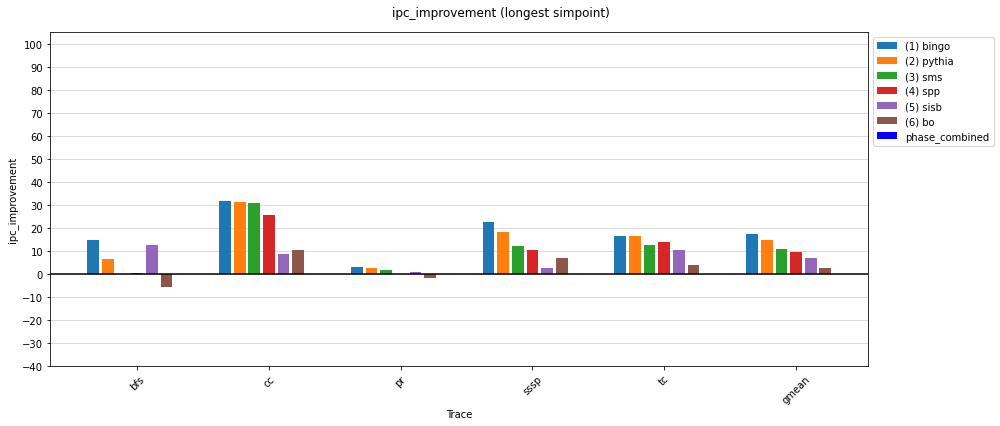

In [10]:
gap_top_single = utils.rank_prefetchers(
    df[df.trace.isin(utils.gap) & df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bo', 'spp', 'pythia'])], 
    'ipc_improvement', 6
)
opp_pref = ['phase_combined']
dpi = None

# MPKI reduction
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='longest',
                           prefetchers=gap_top_single,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.gap,
                           ymin=-5, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/mpki_reduction_single_gap.pdf')

# DRAM bw reduction
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='longest',
                           prefetchers=gap_top_single,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.gap,
                           ymin=-60, ymax=60, dpi=dpi)
plt.savefig('plots/zoo-stats/dram_bw_reduction_single_gap.pdf')

# IPC improvement
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='longest',
                           prefetchers=gap_top_single,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.gap,
                           ymin=-40, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/ipc_improvement_single_gap.pdf')

---
## CloudSuite cumulative statistics

### Top 5 by IPC improvement

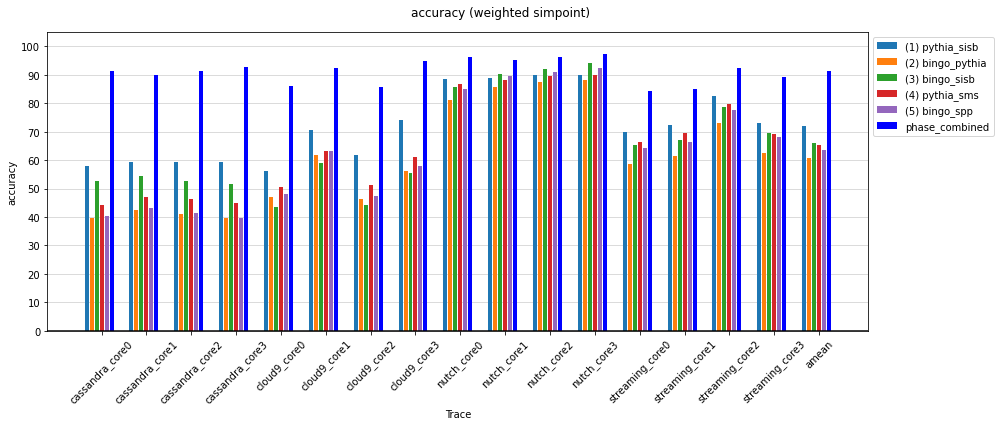

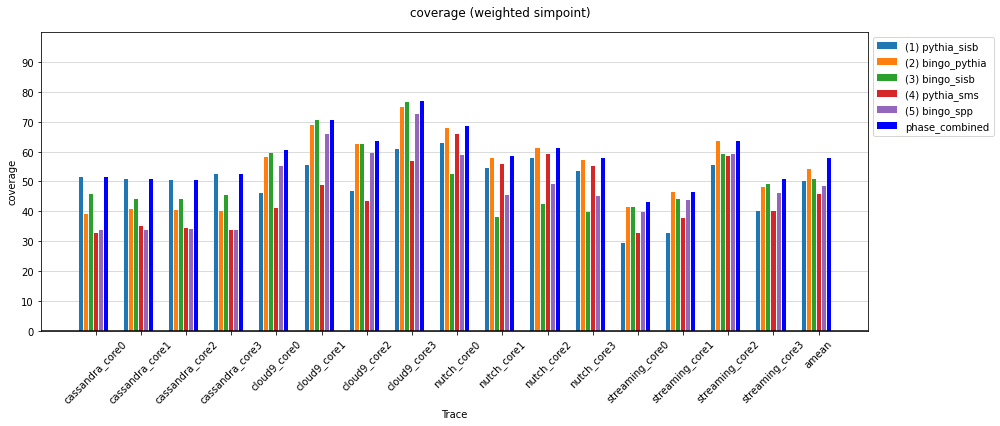

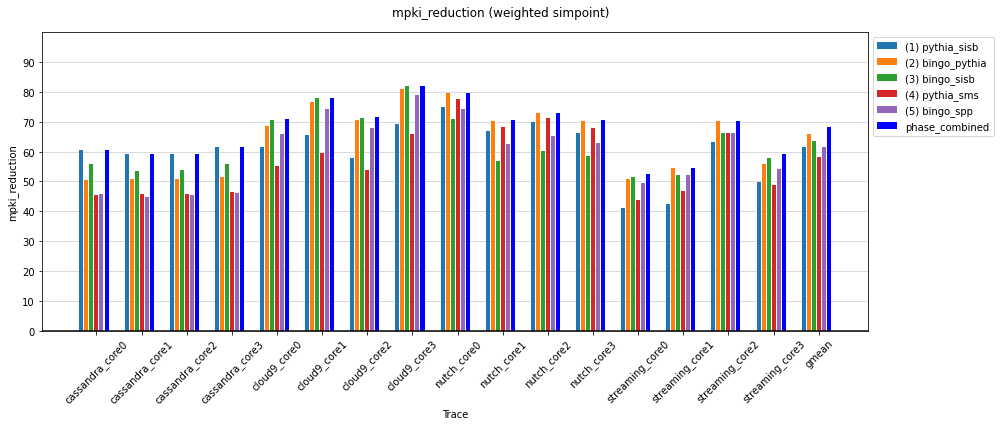

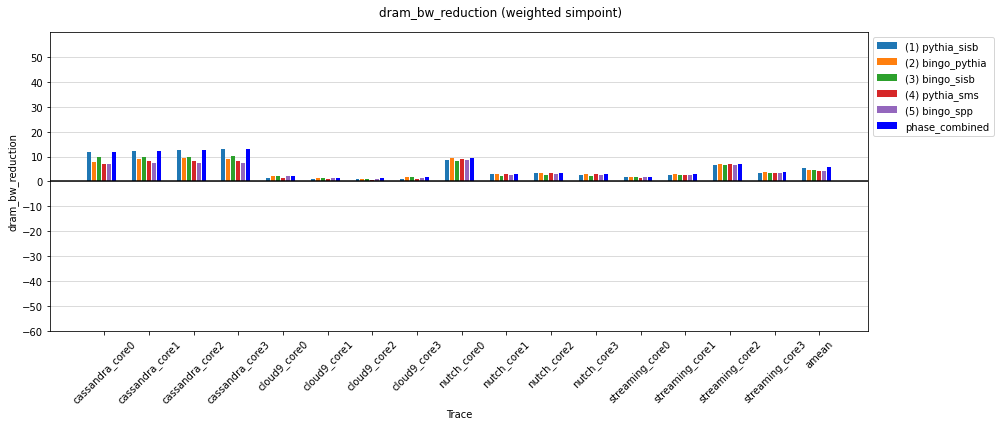

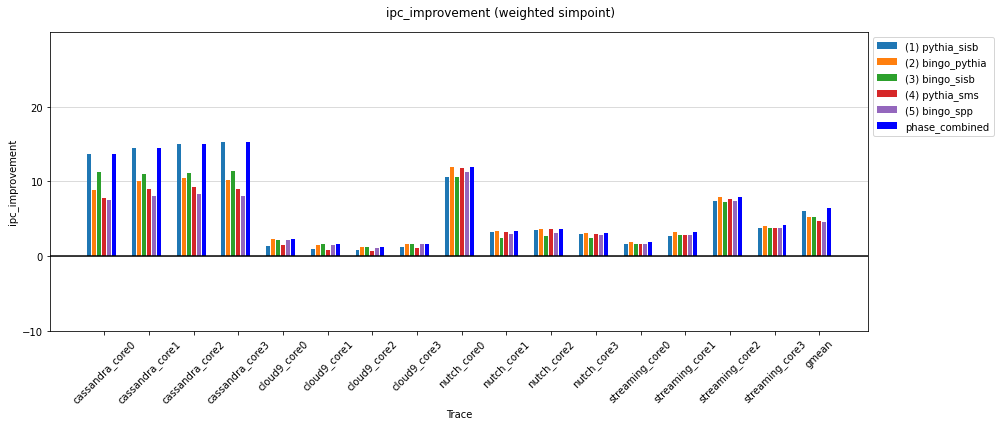

In [11]:
cs_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.cloudsuite)], 'ipc_improvement', 5)
opp_pref = ['phase_combined']
dpi = None

# Accuracy
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=0, ymax=105, dpi=dpi)

# Coverage
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=0, ymax=100, dpi=dpi)

# MPKI reduction
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=0, ymax=100, dpi=dpi)
plt.savefig('plots/zoo-stats/mpki_reduction_5_cloudsuite.pdf')

# DRAM bw reduction
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=-60, ymax=60, dpi=dpi)
plt.savefig('plots/zoo-stats/dram_bw_reduction_5_cloudsuite.pdf')

# IPC improvement
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=-10, ymax=30, dpi=dpi)
plt.savefig('plots/zoo-stats/ipc_improvement_5_cloudsuite.pdf')